In [1]:
import torch

from torch.utils.data import DataLoader

from transformers import AutoTokenizer
from datasets import load_dataset
from transformers import AutoModelForCausalLM

from datetime import datetime
from pathlib import Path

from matplotlib import pyplot as plt

from accelerate import Accelerator

# import tensor dataset and data loader
from torch.utils.data import TensorDataset, DataLoader

from icecream import ic

In [2]:
# generate_paths.py generates this data

# There are 63 batches and 24 layers
# We begin my taking the input of the first layer as the start and the output of the last layer as the end
# NOTE: This is the hardest problem since there is the most non-linearity in the model
def read_data():
    starts = []
    ends = []
    for i in range(63):
        start = torch.load(f"../data/paths/2024-01-01_18-43-27/transformer_layer_0_inputs_batch_{i}.pt")
        end = torch.load(f"../data/paths/2024-01-01_18-43-27/transformer_layer_23_outputs_batch_{i}.pt")
        starts.append(start)
        ends.append(end)

    starts = torch.cat(starts)
    ends = torch.cat(ends)
    return starts, ends

starts, ends = read_data()

In [3]:
# 1000 paths, each living in 2048 dimensions, and having 64 steps
ic(starts.shape)
ic(ends.shape)

ic| starts.shape: torch.Size([1000, 64, 2048])
ic| ends.shape: torch.Size([1000, 64, 2048])


torch.Size([1000, 64, 2048])

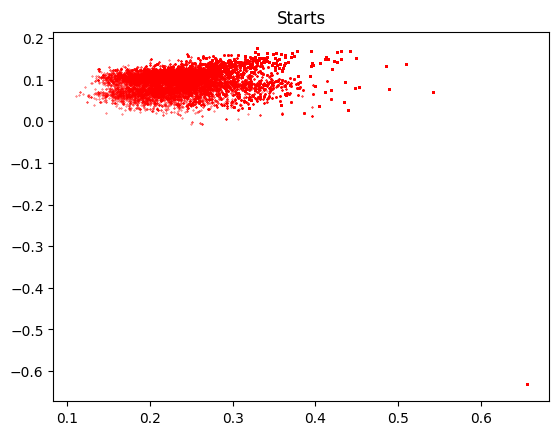

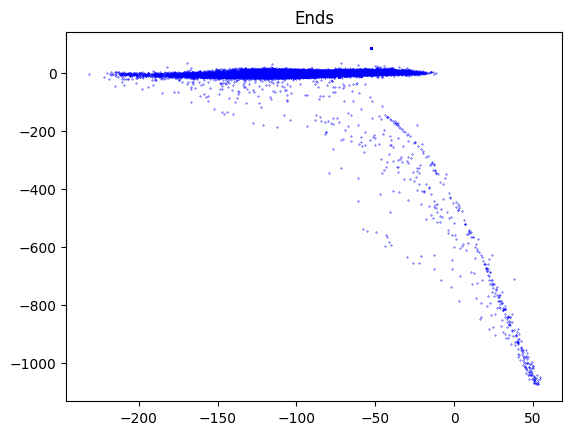

In [4]:
# Project the data using PCA
def project_data(X, n_components=2):
    X = X.reshape(-1, X.shape[-1])
    _, _, V = torch.svd(X)
    X = torch.matmul(X, V[:, :n_components])   
    return X

plt.title("Starts")
plt.scatter(*project_data(starts, n_components=2).detach().cpu().T, s=0.1,c='r')
plt.show()

plt.title("Ends")
plt.scatter(*project_data(ends, n_components=2).detach().cpu().T, s=0.1,c='b')
plt.show()

In [5]:
# Create a linear that maps from the start points to the end points.  
# NOTE: This is not "path aware" since it just works on the points

# This is actually the first term of the Taylor expansion of the function that maps from the start to the end
# So, why not use that first before messing with the neural network?

def linear_map(starts, ends, project_dim=None, align=False, verbose=False):
    # NOTE: This has to all be done without gradients.  First, this is not something
    # we want to train.  Second, it is not possible to do this with gradients since
    # the gradients would be very large for the SVD.
    with torch.no_grad():
        path_length = starts.shape[1]
        start_points = starts.reshape(-1, starts.shape[2])
        end_points = ends.reshape(-1, ends.shape[2])

        if project_dim is None:
            project_dim = start_points.shape[-1]
        else:
            start_points = project_data(start_points, project_dim)
            end_points = project_data(end_points, project_dim)

        if verbose:
            ic(torch.linalg.norm(end_points - start_points))

        if align:
            out = torch.linalg.lstsq(end_points, start_points)
            end_points =  torch.matmul(end_points, out.solution)

        if verbose and align:
            ic(out.solution.shape)

            # Compute the singular values
            singular_values = torch.linalg.svdvals(out.solution)
            # Compute the condition number
            condition_number = singular_values.max() / singular_values.min()
            # pring the minimum and maximum singular values
            ic(singular_values.min())
            ic(singular_values.max())
            ic(condition_number)

            ic(torch.linalg.norm(end_points - start_points))

        return start_points.reshape(-1, path_length, project_dim), end_points.reshape(-1, path_length, project_dim)

starts_mapped, ends_mapped = linear_map(starts, ends, verbose=True, project_dim=2, align=True)

ic(starts_mapped.shape)
ic(ends_mapped.shape)

starts_mapped = starts_mapped[:, :, :2]
ends_mapped = ends_mapped[:, :, :2]

ic(starts_mapped.shape)
ic(ends_mapped.shape)


ic| torch.linalg.norm(end_points - start_points): tensor(30116.9531, device='cuda:0')
ic| out.solution.shape: torch.Size([2, 2])
ic| singular_values.min(): tensor(0.0015, device='cuda:0')
ic| singular_values.max(): tensor(0.0035, device='cuda:0')
ic| condition_number: tensor(2.2884, device='cuda:0')
ic| torch.linalg.norm(end_points - start_points): tensor(64.1292, device='cuda:0')
ic| starts_mapped.shape: torch.Size([1000, 64, 2])
ic| ends_mapped.shape: torch.Size([1000, 64, 2])
ic| starts_mapped.shape: torch.Size([1000, 64, 2])
ic| ends_mapped.shape: torch.Size([1000, 64, 2])


torch.Size([1000, 64, 2])

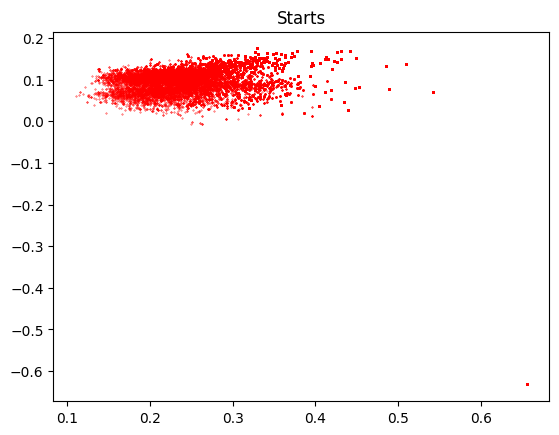

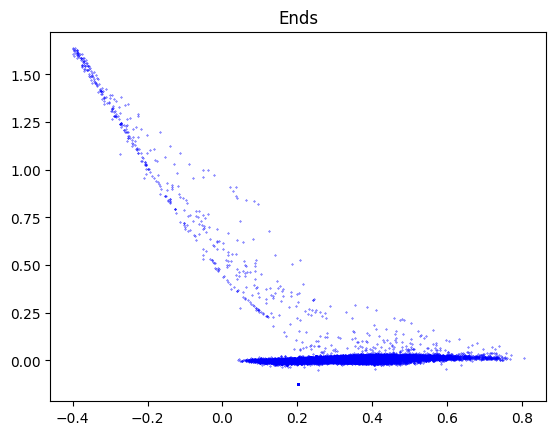

In [6]:
plt.title("Starts")
plt.scatter(*project_data(starts_mapped).detach().cpu().T, s=0.1, c='r')
plt.show()

plt.title("Ends")
plt.scatter(*project_data(ends_mapped).detach().cpu().T, s=0.1, 
            c='b')
plt.show()

In [7]:
dataset = TensorDataset(starts_mapped, ends_mapped)
dataloader = DataLoader(dataset, batch_size=8)

In [8]:
# Run an LSTM on the data
class LSTM(torch.nn.Module):
    def __init__(self, hidden_size=64, num_layers=4, dropout=0.5):
        super().__init__()
        ic(starts_mapped.shape)
        ic(ends_mapped.shape)
        self.lstm = torch.nn.LSTM(starts_mapped.shape[-1], hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.linear = torch.nn.Linear(hidden_size, ends_mapped.shape[-1])

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

model = LSTM()

ic| starts_mapped.shape: torch.Size([1000, 64, 2])
ic| ends_mapped.shape: torch.Size([1000, 64, 2])


In [9]:
# Train the model
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.MSELoss()

In [10]:
# use the accelerator for distributed training
accelerator = Accelerator()
model, optimizer, dataloader = accelerator.prepare(model, optimizer, dataloader)

In [11]:
for epoch in range(1000):
    for i, (start, end) in enumerate(dataloader):
        optimizer.zero_grad()
        out = model(start)
        loss = loss_fn(out, end)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f'epoch: {epoch}, batch: {i}, loss: {loss}')            

epoch: 0, batch: 124, loss: 0.018689697608351707
epoch: 10, batch: 124, loss: 0.010695772245526314
epoch: 20, batch: 124, loss: 0.008538192138075829
epoch: 30, batch: 124, loss: 0.00793489534407854
epoch: 40, batch: 124, loss: 0.007901022210717201
epoch: 50, batch: 124, loss: 0.007888094522058964
epoch: 60, batch: 124, loss: 0.007601545192301273
epoch: 70, batch: 124, loss: 0.007539053913205862
epoch: 80, batch: 124, loss: 0.007972345687448978
epoch: 90, batch: 124, loss: 0.007335761096328497
epoch: 100, batch: 124, loss: 0.007706714794039726
epoch: 110, batch: 124, loss: 0.006799427792429924
epoch: 120, batch: 124, loss: 0.00742562860250473
epoch: 130, batch: 124, loss: 0.006361748091876507
epoch: 140, batch: 124, loss: 0.007342624012380838
epoch: 150, batch: 124, loss: 0.0067807091400027275
epoch: 160, batch: 124, loss: 0.007033076137304306
epoch: 170, batch: 124, loss: 0.0056412918493151665
epoch: 180, batch: 124, loss: 0.006670242175459862
epoch: 190, batch: 124, loss: 0.0053350082

In [12]:
# get a single sample from the dataloader and predict the path
start, end = next(iter(dataloader))

# predict the path
pred = model(start)


In [13]:
start.shape, end.shape, pred.shape

(torch.Size([8, 64, 2]), torch.Size([8, 64, 2]), torch.Size([8, 64, 2]))

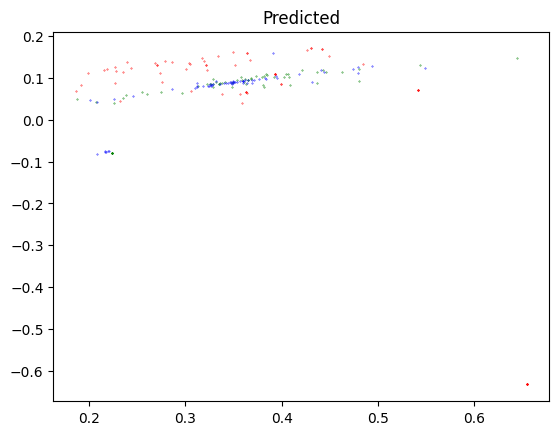

In [14]:
plt.scatter(*start[0].detach().cpu().T, s=0.1, c='r')
plt.scatter(*end[0].detach().cpu().T, s=0.1, c='g')
plt.scatter(*pred[0].detach().cpu().T, s=0.1, c='b')
plt.show()


In [15]:
# start is a collection of points in 2D. Plot them as a path using quiver in matplotlib.
# Each of the points is a vector in 2D.  We can plot the path by plotting the vectors
# from one point to the next.  The first point is the origin.  The second point is the
# first vector.  The third point is the first vector plus the second vector.  And so on.
# This is the path that the model is trying to predict.
def plot_path(start, c='r', label=None):
    # get the path
    path = start.detach().cpu().numpy()
    # get the vectors
    vectors = path[1:] - path[:-1]
    # get the start points of the vectors
    start_points = path[:-1]
    # plot the path
    plt.quiver(*start_points.T, *vectors.T, scale_units='xy', angles='xy', scale=1, color=c, label=label)



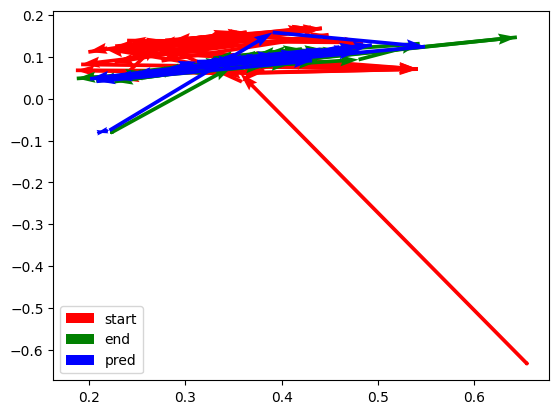

In [16]:
plot_path(start[0], c='r', label='start')
plot_path(end[0], c='g', label='end')
plot_path(pred[0], c='b', label='pred')
plt.legend()